# Test processing UA snow data on the fly

---
J. Michelle Hu  
University of Utah  
December 2024  

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import pyproj
import xarray as xr
from pathlib import PurePath
import rioxarray
import geopandas as gpd

# import datetime

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')
import processing as proc

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
CONDA_ENV = 'studio'
miniconda_dir = '/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3'
proj_version = h.fn_list(miniconda_dir, f'envs/{CONDA_ENV}/conda-meta/proj-[0-9]*.json')[0]

VERSION = PurePath(proj_version).stem

pyprojdatadir = f'{miniconda_dir}/pkgs/{VERSION}/share/proj'
print(pyprojdatadir)
pyproj.datadir.set_data_dir(pyprojdatadir)

# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ'] = pyprojdatadir
os.environ['PROJLIB'] = pyprojdatadir
os.environ['PROJ_LIB'] = pyprojdatadir

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.4.1-h54d7996_1/share/proj


## Read in one of the files (these are the 800 m products)

Files are organized in water years!

In [4]:
mmap_name = 'https://climate.arizona.edu/data/UA_SWE/DailyData_800m/WY2021/UA_SWE_Depth_800m_v1_20210101_stable.nc'
_, dataset = rioxarray.open_rasterio(mmap_name, masked=True, chunks='auto')
dataset

/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/studio/lib/python3.12/site-packages/rioxarray/_io.py:1136: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  warnings.warn(str(rio_warning.message), type(rio_warning.message))  # type: ignore


<xarray.Dataset> Size: 175MB
Dimensions:  (x: 7025, y: 3105, time: 1)
Coordinates:
  * x        (x) float64 56kB -125.0 -125.0 -125.0 ... -66.5 -66.49 -66.48
  * y        (y) float64 25kB 49.93 49.92 49.92 49.91 ... 24.08 24.08 24.07
  * time     (time) object 8B 2021-01-01 00:00:00
    crs      int64 8B 0
Data variables:
    SWE      (time, y, x) float32 87MB dask.array<chunksize=(1, 3105, 7025), meta=np.ndarray>
    DEPTH    (time, y, x) float32 87MB dask.array<chunksize=(1, 3105, 7025), meta=np.ndarray>

In [5]:
# Set the projection to 4326
dataset.rio.set_crs(4326, inplace=True)

/scratch/local/u6058223/ipykernel_1798030/1262442187.py:2: FutureWarning: It is recommended to use 'rio.write_crs()' instead. 'rio.set_crs()' will likelybe removed in a future release.
  dataset.rio.set_crs(4326, inplace=True)


<xarray.Dataset> Size: 175MB
Dimensions:  (x: 7025, y: 3105, time: 1)
Coordinates:
  * x        (x) float64 56kB -125.0 -125.0 -125.0 ... -66.5 -66.49 -66.48
  * y        (y) float64 25kB 49.93 49.92 49.92 49.91 ... 24.08 24.08 24.07
  * time     (time) object 8B 2021-01-01 00:00:00
    crs      int64 8B 0
Data variables:
    SWE      (time, y, x) float32 87MB dask.array<chunksize=(1, 3105, 7025), meta=np.ndarray>
    DEPTH    (time, y, x) float32 87MB dask.array<chunksize=(1, 3105, 7025), meta=np.ndarray>

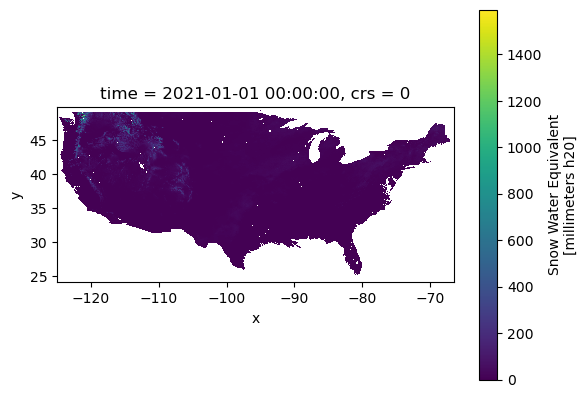

In [6]:
fig, ax = plt.subplots()
dataset['SWE'].isel(time=0).plot.imshow(ax=ax)
ax.set_aspect('equal')

### Extracting on the fly seems to work just fine, but this is day by day. what about for the whole year?

In [7]:
var = 'SWE'

Bounding box selection

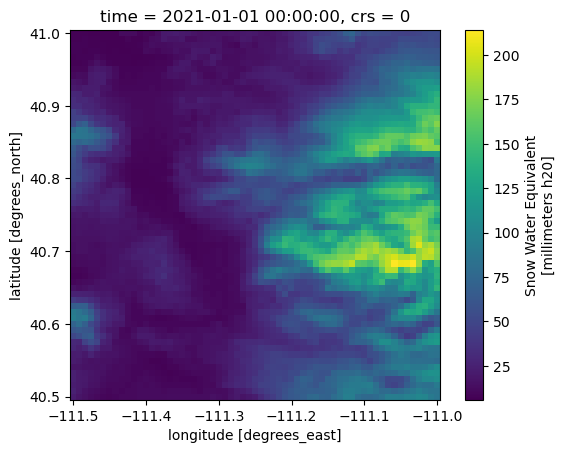

In [8]:
# select by bounding box
xmin, xmax, ymin, ymax = -111.5, -111.0, 40.5, 41.0
bbox_clip = dataset[var].isel(time=0).rio.clip_box(minx=xmin, maxx=xmax, miny=ymin, maxy=ymax)
fig, ax = plt.subplots()
bbox_clip.plot.imshow(ax=ax)
ax.set_aspect('equal')

Polygon selection

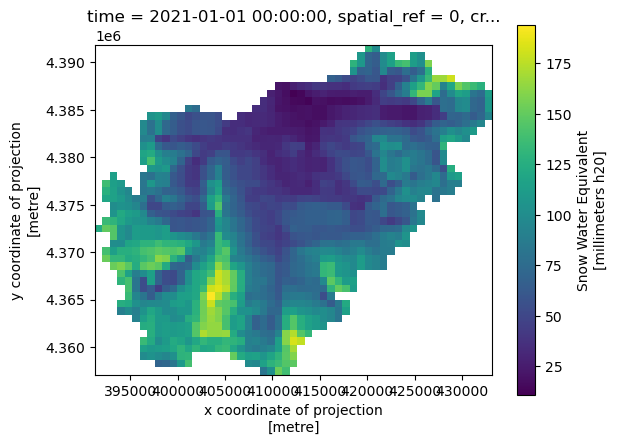

In [9]:
# select by polygon
poly_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/jmhu/isnobal_scripts/blue_river_setup/polys/blue_river_basin_outline_HUC10dissolved_32613.shp'
# read in polygon
poly = gpd.read_file(poly_fn)
# first reproject to polygon CRS
dataset_reproj = dataset.rio.reproject(poly.crs)
# dataset_reproj['SWE'].isel(time=0).plot.imshow()
poly_clip = dataset_reproj[var].isel(time=0).rio.clip(poly.geometry)
fig, ax = plt.subplots()
poly_clip.plot.imshow(ax=ax)
ax.set_aspect('equal')

Point selection

In [10]:
# select by point (in polygon projected coords)
allsites_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/ancillary_sdswe_products/SNOTEL/snotel_sites_32613.json'
WY = 2021

# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)
# Get site names and site numbers
sitenames = found_sites['site_name']
sitenums = found_sites['site_num']
ST_arr = ['CO'] * len(sitenums)
gdf_metloom, snotel_dfs = proc.get_snotel(sitenums, sitenames, ST_arr, WY=WY)

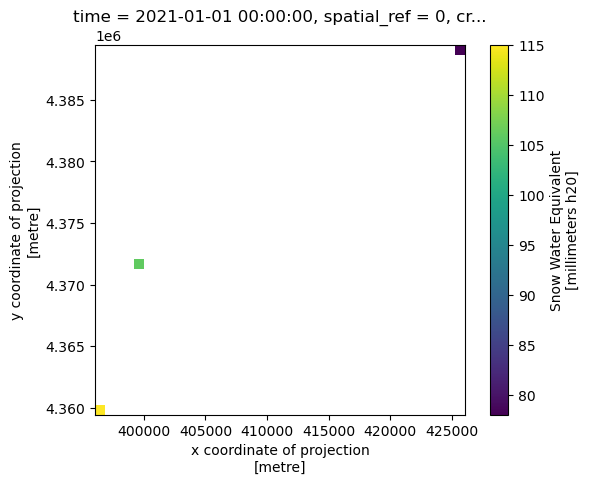

In [11]:
# Get all the point clips at once
points_clip = dataset_reproj[var].rio.clip(gdf_metloom.geometry)
fig, ax = plt.subplots()
points_clip.plot(ax=ax)
ax.set_aspect('equal')

In [12]:
# Just get the values
point_vals = dataset_reproj[var].rio.clip(gdf_metloom.geometry).values[~np.isnan(dataset_reproj[var].rio.clip(gdf_metloom.geometry).values)]
print(point_vals)

[ 78. 106. 115.]


In [13]:
# Select just one point
point = gdf_metloom.loc[0]
point_clip = dataset_reproj[var].rio.clip(point)
point_clip

<xarray.DataArray 'SWE' (time: 1, y: 1, x: 1)> Size: 4B
array([[[106.]]], dtype=float32)
Coordinates:
  * x            (x) float64 8B 3.996e+05
  * y            (y) float64 8B 4.372e+06
  * time         (time) object 8B 2021-01-01 00:00:00
    spatial_ref  int64 8B 0
    crs          int64 8B 0
Attributes:
    lat#long_name:           latitude
    lat#units:               degrees north
    lon#long_name:           longitude
    lon#units:               degrees east
    NETCDF_DIM_EXTRA:        {time}
    NETCDF_DIM_time_DEF:     [1. 5.]
    NETCDF_DIM_time_VALUES:  44195
    long_name:               Snow Water Equivalent
    units:                   millimeters h20
    scale_factor:            1.0
    add_offset:              0.0

Dataset bound selection

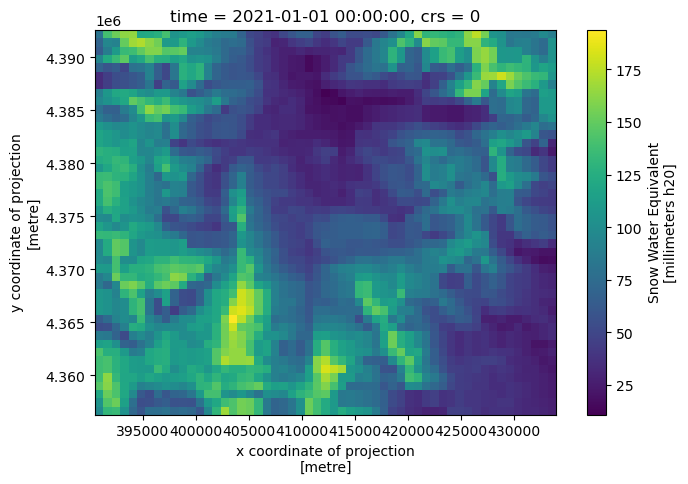

In [14]:
# select by another dataset's bounds
# isnobal snow.nc for a single date
# isnobal_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/animas_100m_isnobal/wy2021/animas_basin_100m/run20210101/snow.nc'
isnobal_fn = '/uufs/chpc.utah.edu/common/home/skiles-group3/model_runs/blue_100m_isnobal/wy2019/blue_basin_100m/run20190101/snow.nc'
isnobal_ds = xr.open_dataset(isnobal_fn, drop_variables=['snow_density', 'specific_mass', 'liquid_water', 'temp_surf', 'temp_lower', 'temp_snowcover', 
                                                         'thickness_lower', 'water_saturation', 'projection'])

isnobal_clip = dataset_reproj['SWE'].isel(time=0).rio.clip_box(minx=isnobal_ds.x.min(), maxx=isnobal_ds.x.max(), miny=isnobal_ds.y.min(), maxy=isnobal_ds.y.max())
fig, ax = plt.subplots(figsize=(8,5))
isnobal_clip.plot.imshow(ax=ax)
ax.set_aspect('equal')


### Now try to read the full water year for time series point extractions

In [15]:
# Modified from https://tutorial.xarray.dev/intermediate/remote_data/remote-data.html ! works!
import fsspec

urls = 'https://climate.arizona.edu/data/UA_SWE/DailyData_800m/WY2021/UA_SWE_Depth_800m_v1_*_stable.nc'

# we prepend the cache type to the URI, this is called protocol chaining in fsspec-speak
file = fsspec.open_local(f"simplecache::{urls}", filecache={'cache_storage': '/tmp/fsspec_cache'})

ds = xr.open_mfdataset(file, engine="netcdf4") #h5netcdf not currently installed
ds

<xarray.Dataset> Size: 64GB
Dimensions:   (time: 365, time_str_len: 11, lat: 3105, lon: 7025)
Coordinates:
  * lat       (lat) float32 12kB 24.07 24.08 24.08 24.09 ... 49.92 49.92 49.93
  * lon       (lon) float32 28kB -125.0 -125.0 -125.0 ... -66.5 -66.49 -66.48
  * time      (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
Dimensions without coordinates: time_str_len
Data variables:
    crs       (time) |S1 365B b'' b'' b'' b'' b'' b'' ... b'' b'' b'' b'' b''
    time_str  (time_str_len, time) |S1 4kB dask.array<chunksize=(11, 1), meta=np.ndarray>
    SWE       (time, lat, lon) float32 32GB dask.array<chunksize=(1, 1553, 3513), meta=np.ndarray>
    DEPTH     (time, lat, lon) float32 32GB dask.array<chunksize=(1, 1553, 3513), meta=np.ndarray>

In [16]:
# Now sample the massive thing for a time series plot

# Resample the SNOTEL gdf to the dataset for quicker selection
gdf_metloom_reproj = gdf_metloom.to_crs(ds.crs.attrs['spatial_ref'])

# Original method as in time_series
ua_data_sampled = ds[var].sel(lon=list(gdf_metloom_reproj.geometry.x.values), 
                                  lat=list(gdf_metloom_reproj.geometry.y.values), 
                                  method='nearest')
ua_data_sampled.load()

<xarray.DataArray 'SWE' (time: 365, lat: 3, lon: 3)> Size: 13kB
array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 5.],
        [0., 0., 0.],
        [1., 3., 0.]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 12B 39.49 39.38 39.65
  * lon      (lon) float32 12B -106.2 -106.2 -105.9
  * time     (time) datetime64[ns] 3kB 2020-10-01 2020-10-02 ... 2021-09-30
Attributes:
    long_name:     Snow Water Equivalent
    grid_mapping:  crs
    units:         millimeters h20

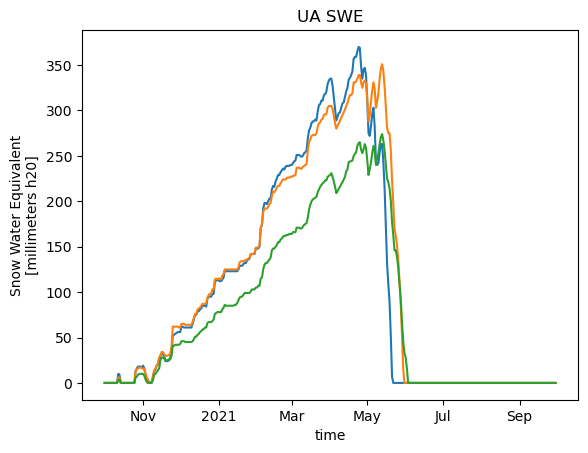

In [17]:
fig, ax = plt.subplots()
for f in range(len(gdf_metloom_reproj)):
    ua_data_sampled[:, f, f].plot(ax=ax)
ax.set_title(f'UA {var}');